# Deep Q-learning

In [1]:
import numpy as np

import jax.numpy as jnp
import jax.random as jrandom

from src.RL.DQLearning import DQLearning
from src.systems.linear import StochasticDoubleIntegrator
import matplotlib.pyplot as plt

(5000,)


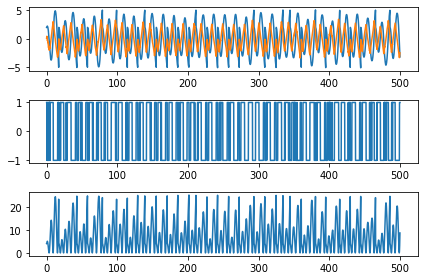

In [3]:
# Train controller
def run_controller(controller, system, T):
    key = jrandom.PRNGKey(0)

    time_horizon = np.arange(0, T, system.dt)

    n_steps = len(time_horizon)
    n_obs = system.dim

    X = np.zeros((n_steps, n_obs))
    U = np.zeros(n_steps)
    C = np.zeros(n_steps)

    training_wheels = 5
    tw_increase = 0

    for ti, t in enumerate(time_horizon):
        key, subkey = jrandom.split(key)
        y0 = system.observe(subkey)
        u_star = controller.get_control(y0)

        # state update
        state, cost = system.update(key, u_star, info=True)
        y1 = system.observe(subkey)

        # learning
        controller.update(y0, y1, u_star, -cost)

        # save state
        X[ti] = state
        U[ti] = u_star
        C[ti] = cost

        if abs(state[0]) >= training_wheels:
            system.reset(x0)
        training_wheels += tw_increase

    return time_horizon, X, U, C, controller



# Initialize system
x0 = np.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

# Choose controler
DQL = DQLearning(SDI.dim)

# Run controller
th, X, U, C, DQL = run_controller(DQL, SDI, 500)
print(U.shape)

fig, ax = plt.subplots(3)
ax[0].plot(th, X[:, 0])
ax[0].plot(th, X[:, -1])
ax[1].plot(th, U)
ax[2].plot(th, C)
plt.tight_layout()

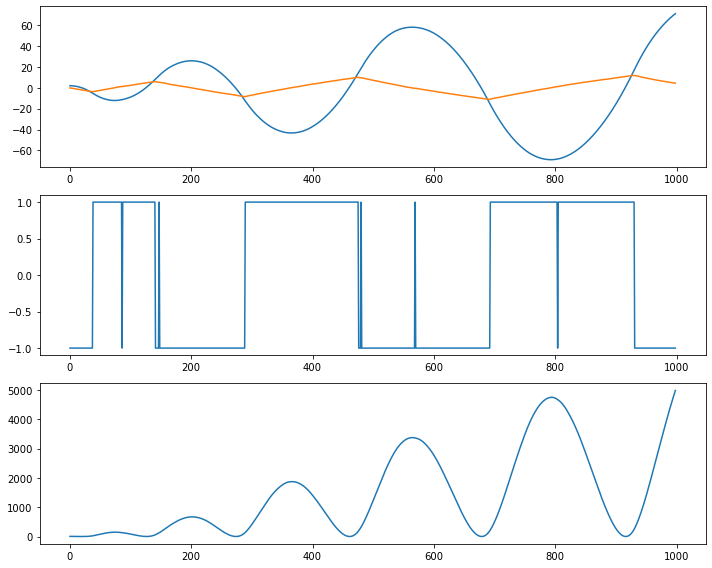

In [33]:
key = jrandom.PRNGKey(0)

n_steps = 1000
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

X = np.zeros((n_steps,2))
C = np.zeros(n_steps-1)
U = np.zeros(n_steps-1)

y0 = SDI.observe(key)
for i in range(0, n_steps-1):
    
    key, subkey = jrandom.split(key)
    y0 = SDI.observe(subkey)
    u_star = DQL.get_control(y0)

    # state update
    state, cost = SDI.update(key, u_star, info=True)
    y1 = SDI.observe(subkey)

    # save state
    X[i] = state
    U[i] = u_star
    C[i] = cost

fig, ax = plt.subplots(3, figsize=(10,8))
ax[0].plot(X[:-1])
ax[1].plot(U)
ax[2].plot(C)
plt.tight_layout()


[[-2044.1078     -24.872591]
 [-2045.2933     -23.311321]]


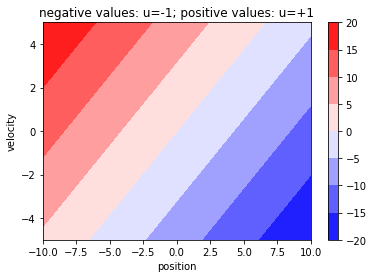

In [25]:
from matplotlib import cm

print(DQL.params)

n=20
x = np.linspace(-10,10,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
z = np.zeros((2, n, n))
for i in range(n):
    for j in range(n):
        qvals = jnp.dot(DQL.params, jnp.array([xv[i,j], yv[i,j]]))
        z[0,i,j] = qvals[0]
        z[1,i,j] = qvals[1]

plt.contourf(xv, yv, z[1] - z[0], cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('negative values: u=-1; positive values: u=+1');
